In [29]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import MinMaxScaler

In [30]:
# Set random seed for reproducibility
np.random.seed(42)

# Load data from csv file
df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2022-07-06,20194.619141,20595.529297,19823.511719,20548.246094,24598943708
2022-07-07,20547.814453,21771.816406,20296.103516,21637.587891,25814972520
2022-07-08,21637.154297,22314.941406,21257.453125,21731.117188,49899834488
2022-07-09,21716.828125,21877.138672,21445.957031,21592.207031,29641127858
2022-07-10,21591.080078,21591.080078,20727.123047,20860.449219,28688807249


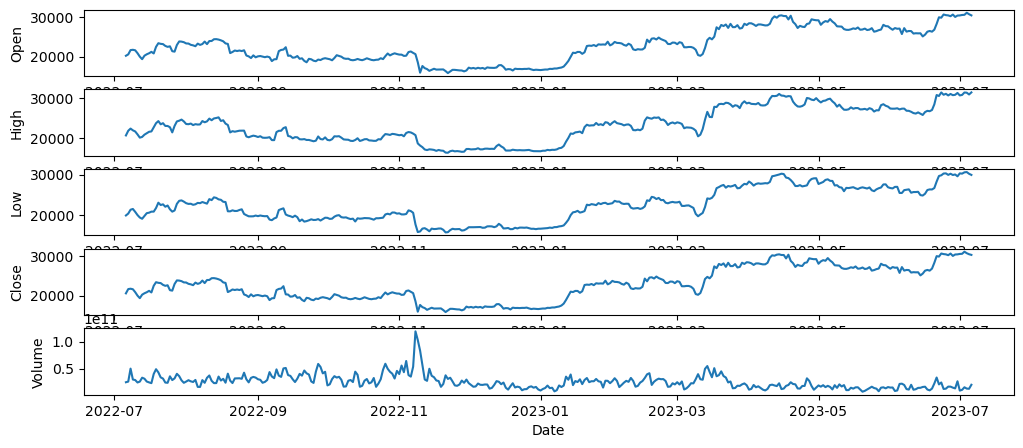

In [31]:
# Plotting
plt.figure(figsize=(12, 5))
for i, col in enumerate(list(df)):
    plt.subplot(len(list(df)), 1, i+1)
    plt.plot(df[col], label=col)
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.xticks(rotation=0)
plt.show()

In [32]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-07-06,20194.619141,20595.529297,19823.511719,20548.246094,24598943708
2022-07-07,20547.814453,21771.816406,20296.103516,21637.587891,25814972520
2022-07-08,21637.154297,22314.941406,21257.453125,21731.117188,49899834488
2022-07-09,21716.828125,21877.138672,21445.957031,21592.207031,29641127858
2022-07-10,21591.080078,21591.080078,20727.123047,20860.449219,28688807249


We will try to predict Temperature with humiduty, Air Pressure, and time

In [33]:
# First move the Temperature column to the rightmost so it is eaiser to wrok with
temp = df['Close']
df.drop('Close', axis=1, inplace=True)
df['Close'] = temp

df.head()

,Open,High,Low,Volume,Close
Date,,,,,
2022-07-06,20194.619141,20595.529297,19823.511719,24598943708,20548.246094
2022-07-07,20547.814453,21771.816406,20296.103516,25814972520,21637.587891
2022-07-08,21637.154297,22314.941406,21257.453125,49899834488,21731.117188
2022-07-09,21716.828125,21877.138672,21445.957031,29641127858,21592.207031
2022-07-10,21591.080078,21591.080078,20727.123047,28688807249,20860.449219


In [34]:
#split the dataset into train and test set
split_n = 0.8 * df.shape[0]
df_test = df[int(split_n):]
df_train = df[:int(split_n)]

In [35]:
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape) 

Train set shape: (292, 5)
Test set shape: (74, 5)


In [36]:
scaler = MinMaxScaler()
scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

In [44]:
def create_dataset(dataset, lookback, predict_window):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window to lookback for training
        predict_window - Defining how many steps forward to predict
    """
    X, y = [], []
    for i in range(len(dataset)-lookback-predict_window):
        feature = dataset[i:i+lookback]
        target = dataset[i+predict_window:i+lookback+predict_window]
        X.append(feature)
        y.append(target)  
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32),

In [70]:
lookback = 4
predict_window = 2
X_train, y_train = create_dataset(scaled_train, lookback=lookback, predict_window=predict_window)
X_test, y_test = create_dataset(scaled_test, lookback=lookback, predict_window=predict_window)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([286, 4, 5]) torch.Size([286, 4, 5])
torch.Size([68, 4, 5]) torch.Size([68, 4, 5])


In [71]:
y_train[0:5]

tensor([[[0.3981, 0.4109, 0.3863, 0.3791, 0.4044],
         [0.4035, 0.3812, 0.3992, 0.1970, 0.3949],
         [0.3949, 0.3618, 0.3501, 0.1885, 0.3452],
         [0.3450, 0.3120, 0.2953, 0.1477, 0.2846]],

        [[0.4035, 0.3812, 0.3992, 0.1970, 0.3949],
         [0.3949, 0.3618, 0.3501, 0.1885, 0.3452],
         [0.3450, 0.3120, 0.2953, 0.1477, 0.2846],
         [0.2847, 0.2569, 0.2533, 0.1626, 0.2406]],

        [[0.3949, 0.3618, 0.3501, 0.1885, 0.3452],
         [0.3450, 0.3120, 0.2953, 0.1477, 0.2846],
         [0.2847, 0.2569, 0.2533, 0.1626, 0.2406],
         [0.2409, 0.2691, 0.2322, 0.2276, 0.3010]],

        [[0.3450, 0.3120, 0.2953, 0.1477, 0.2846],
         [0.2847, 0.2569, 0.2533, 0.1626, 0.2406],
         [0.2409, 0.2691, 0.2322, 0.2276, 0.3010],
         [0.3011, 0.3075, 0.2793, 0.2107, 0.3254]],

        [[0.2847, 0.2569, 0.2533, 0.1626, 0.2406],
         [0.2409, 0.2691, 0.2322, 0.2276, 0.3010],
         [0.3011, 0.3075, 0.2793, 0.2107, 0.3254],
         [0.3257, 0.331

In [72]:
X_train[0:5]

tensor([[[0.3000, 0.2944, 0.2884, 0.1517, 0.3239],
         [0.3240, 0.3741, 0.3207, 0.1627, 0.3980],
         [0.3981, 0.4109, 0.3863, 0.3791, 0.4044],
         [0.4035, 0.3812, 0.3992, 0.1970, 0.3949]],

        [[0.3240, 0.3741, 0.3207, 0.1627, 0.3980],
         [0.3981, 0.4109, 0.3863, 0.3791, 0.4044],
         [0.4035, 0.3812, 0.3992, 0.1970, 0.3949],
         [0.3949, 0.3618, 0.3501, 0.1885, 0.3452]],

        [[0.3981, 0.4109, 0.3863, 0.3791, 0.4044],
         [0.4035, 0.3812, 0.3992, 0.1970, 0.3949],
         [0.3949, 0.3618, 0.3501, 0.1885, 0.3452],
         [0.3450, 0.3120, 0.2953, 0.1477, 0.2846]],

        [[0.4035, 0.3812, 0.3992, 0.1970, 0.3949],
         [0.3949, 0.3618, 0.3501, 0.1885, 0.3452],
         [0.3450, 0.3120, 0.2953, 0.1477, 0.2846],
         [0.2847, 0.2569, 0.2533, 0.1626, 0.2406]],

        [[0.3949, 0.3618, 0.3501, 0.1885, 0.3452],
         [0.3450, 0.3120, 0.2953, 0.1477, 0.2846],
         [0.2847, 0.2569, 0.2533, 0.1626, 0.2406],
         [0.2409, 0.269

In [73]:
# Create a custom neural network model
class TimeSeriesModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(TimeSeriesModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  
        """
        inputs need to be in the right shape as defined in documentation
        ( https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html )
        
        x - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        # Initialize hidden state
        hidden_state = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        cell_state = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        self.hidden = (hidden_state, cell_state)
     
        # Forward Pass
        x, hidden = self.rnn(x, self.hidden) # (input, hidden, and internal state)
        out = self.fc(x)
        return out

In [74]:
# Define search space for hyperparameters
space = {
    'num_epochs': hp.choice('num_epochs', range(30, 200)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.01)),
    'num_layers': hp.choice('num_layers', range(1, 9)),
    'hidden_size': hp.choice('hidden_size', range(32, 94))
}

# Define objective function to minimize
def objective(params):
    num_epochs = params['num_epochs']
    learning_rate = params['learning_rate']
    num_layers = params['num_layers']
    hidden_size = params['hidden_size']
    
    print(params)

    # Create the model
    input_size=X_train.shape[2]
    output_size=y_train.shape[2]
    model = TimeSeriesModel(input_size, hidden_size, output_size, num_layers)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define loader
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)

    # Initialize early stopping
    patience = 18
    best_loss = np.inf
    early_stop_counter = 0

    # Training loop
    for epoch in range(num_epochs):
        # set model to training mode
        model.train()
        
       
        for X_batch, y_batch in train_loader:
            # Forward pass
            output = model(X_batch)
            train_loss = criterion(output, y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        # Validate the model
        model.eval() #set the model to testing mode
        
        with torch.inference_mode():
            y_pred = model(X_test)
            val_loss = criterion(y_pred, y_test)

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'NN early stopping activated after {epoch} epochs!')
                break

    return {'loss': val_loss.item(), 'status': STATUS_OK, 'model': model}

In [75]:
# Run hyperparameter optimization with early stopping
trials = Trials()

def hyperopt_early_stopping(trials, count=0, best_loss=np.inf):
    # Get the best trial's loss from the trials object
    # Check if the best loss is not improved
    if trials.trials[-1]['result']['loss'] >= best_loss:
        # Stop if the current count is equal to or greater than 10
        return count + 1 >= 10, [count + 1, trials.best_trial['result']['loss']]
    # If it improves then return False and reset count to 0
    else:
        return False, [0, trials.best_trial['result']['loss']]


best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials, early_stop_fn=hyperopt_early_stopping)


{'hidden_size': 79, 'learning_rate': 0.0029091672818256312, 'num_epochs': 97, 'num_layers': 6}                         
NN early stopping activated after 25 epochs!                                                                           
{'hidden_size': 51, 'learning_rate': 0.0023505638239608314, 'num_epochs': 91, 'num_layers': 2}                         
NN early stopping activated after 45 epochs!                                                                           
{'hidden_size': 74, 'learning_rate': 0.005210370872508152, 'num_epochs': 137, 'num_layers': 2}                         
NN early stopping activated after 61 epochs!                                                                           
{'hidden_size': 50, 'learning_rate': 0.003985473122491041, 'num_epochs': 188, 'num_layers': 1}                         
NN early stopping activated after 92 epochs!                                                                           
{'hidden_size': 76, 'learning_rate': 0.0

In [76]:
# Retrieve the best model
best_model = trials.best_trial['result']['model']

# Print best hyperparameters
print('Best hyperparameters:')
print(best)
print('Best model:')
print(best_model)

Best hyperparameters:
{'hidden_size': 18, 'learning_rate': 0.003985473122491041, 'num_epochs': 158, 'num_layers': 0}
Best model:
TimeSeriesModel(
  (rnn): LSTM(5, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=5, bias=True)
)


In [77]:
best_model.state_dict()['fc.weight']

tensor([[-0.0795, -0.1140, -0.1647, -0.0218,  0.1220, -0.0637,  0.1777, -0.0981,
          0.2863, -0.1601,  0.1553, -0.1379,  0.0796,  0.0636,  0.0152,  0.2044,
         -0.1443, -0.0699,  0.0007,  0.0287, -0.3010, -0.1486,  0.1309,  0.3465,
         -0.1664,  0.2140, -0.1113, -0.0589, -0.0385, -0.0888,  0.1874,  0.0641,
          0.0215, -0.0424, -0.0314,  0.1727,  0.0064,  0.2420, -0.0506,  0.3223,
         -0.1712,  0.0979, -0.1252,  0.0619, -0.0377,  0.1529,  0.1753, -0.0452,
          0.0085, -0.0215],
        [-0.3026, -0.0265,  0.0674, -0.0552,  0.1099, -0.2053,  0.0242, -0.0660,
          0.3214, -0.0708,  0.1766, -0.1790,  0.0492,  0.1024,  0.0070,  0.3753,
         -0.0628, -0.1422, -0.0302,  0.0042, -0.2177, -0.2616, -0.0314,  0.3142,
         -0.3100, -0.0057, -0.1029,  0.1413, -0.1038, -0.1240,  0.1120, -0.0613,
          0.0228, -0.0128,  0.0512,  0.1602,  0.1980,  0.1115, -0.0872,  0.2433,
         -0.2098,  0.0155, -0.1336,  0.0795, -0.1953,  0.2646,  0.0565, -0.1912,


In [78]:
best_model.state_dict()['fc.bias']

tensor([0.1330, 0.1177, 0.0621, 0.0606, 0.0783])

In [79]:
# Generate predictions using the trained model
best_model.eval()

with torch.inference_mode():
            y_pred = best_model(X_test)

y_pred = y_pred[: , -1, :]
#print(y_pred)

In [80]:
scaled_df = scaler.transform(df)
X_df, y_df = create_dataset(scaled_df, lookback=lookback, predict_window=predict_window)

with torch.inference_mode():
    df_pred = best_model(X_df) # get prediction of the best train set

df_pred = df_pred[: , -1, :] # Get only the last prediction and only the last column which is the closing price    

df_pred = df_pred.data.numpy() # numpy conversion

df_pred = scaler.inverse_transform(df_pred) # reverse transformation

In [81]:
df_pred[:5]

array([[2.1824197e+04, 2.2352771e+04, 2.1412500e+04, 2.7773745e+10,
        2.1842467e+04],
       [2.0766002e+04, 2.1290057e+04, 2.0319725e+04, 3.1064119e+10,
        2.0776893e+04],
       [1.9869902e+04, 2.0353307e+04, 1.9428486e+04, 3.1416117e+10,
        1.9903785e+04],
       [1.9449021e+04, 1.9977387e+04, 1.9126027e+04, 2.8134527e+10,
        1.9688018e+04],
       [2.0463262e+04, 2.1063188e+04, 2.0156020e+04, 3.0923510e+10,
        2.0763381e+04]], dtype=float32)

In [82]:
preds = [np.nan] * (lookback + predict_window)
for i in range(len(df_pred)):
    preds.append(df_pred[i][-1])

print(preds[:10])

[nan, nan, nan, nan, nan, nan, 21842.467, 20776.893, 19903.785, 19688.018]


In [83]:
len(preds)

366

In [84]:
df.shape

(366, 5)

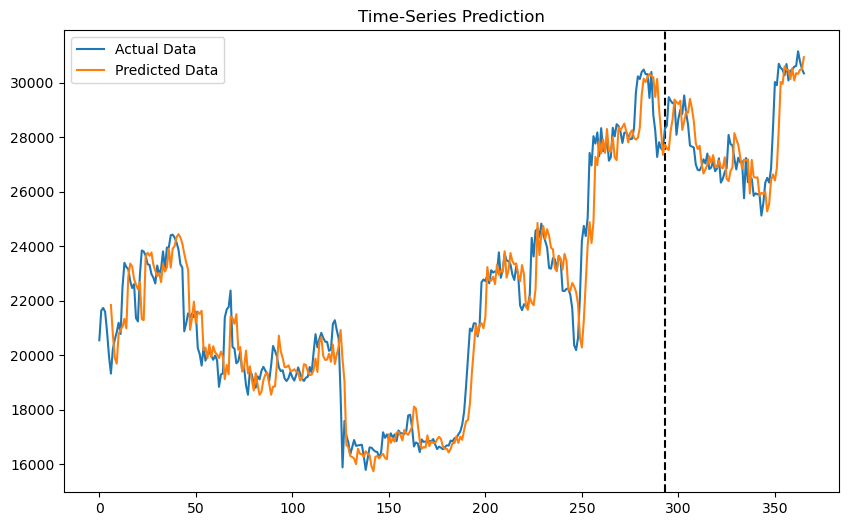

In [85]:
plt.figure(figsize=(10,6)) #plotting
train_test_cutoff = round(split_n)

plt.axvline(x=train_test_cutoff, c='0', linestyle='--') # size of the training set

plt.plot(df['Close'].to_numpy(), label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 